In [3]:
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
from torch import nn
import torch.nn.functional as F
import torchzero as tz
from visualbench import FunctionDescent, test_functions

# Second order methods
Second order methods use second order information, i.e. the hessian matrix. They converge very quickly, however they tend to be expensive to compute.

### Newton's method
**Newton's method**, also known as Newton–Raphson method, is a root-find methot used to find solutions to equation $f(x)=0$.

In order to use Newton's method to minimize a function, we can use it to find solutions to $f'(x)=0$, i.e. the critical points. As long as $f$ is twice-differentiable, any solution to $f'(x)=0$ is either the minimum or the maximum. Therefore if the function has a maximum, one needs to be careful as standard Newton's method may converge to it instead of the desired minimum.


The Newton iteration is:
$$
x_{t+1} \leftarrow x_t - H(x_t)^{-1}\nabla f(x_t)
$$

So on each step inverse hessian times gradient is subtracted from parameters.

Another interpretation of the Newton's method is that it constructs and minimizes a quadratic approximation of the objective function. Therefore if the objective function is quadratic, the approximation will be perfect and Newton's method converges in a single step.

finished in 0.5s., reached loss = 0.000146                                      
finished in 0.3s., reached loss = 0                                      


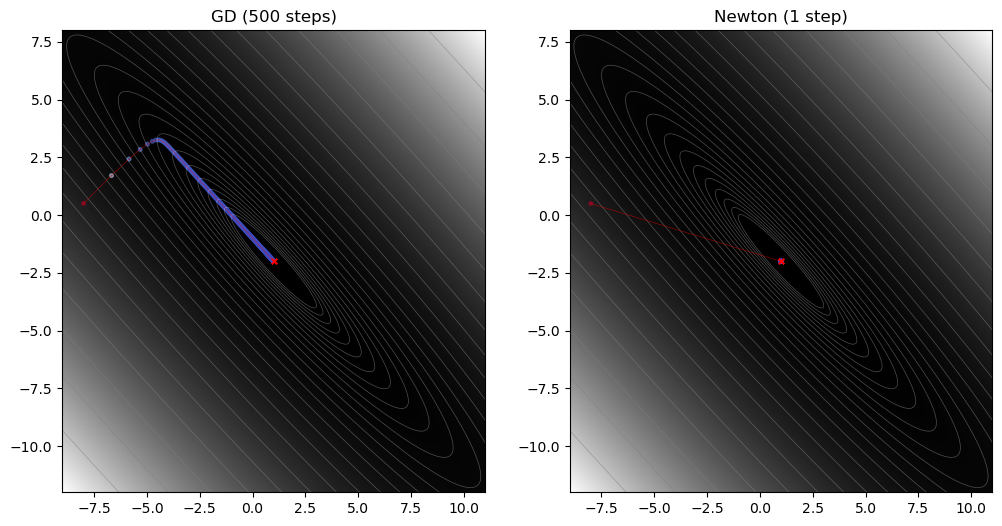

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))

# GD
func = FunctionDescent('ill1')
optimizer = tz.Modular(func.parameters(), tz.m.LR(1e-1))
func.run(optimizer, max_steps=500)
func.plot(log_contour=True, ax=ax[0])
ax[0].set_title("GD (500 steps)")

# Newton
func = FunctionDescent('ill1')
optimizer = tz.Modular(func.parameters(), tz.m.Newton(), tz.m.LR(1))
func.run(optimizer, max_steps=100)
func.plot(log_contour=True, ax=ax[1])
ax[1].set_title("Newton (1 step)")

plt.show()